<a href="https://colab.research.google.com/github/jumafernandez/imbalanced_data/blob/main/notebooks/oversampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación de estrategias de Oversampling

__Autor:__ Juan Manuel Fernandez

__Objetivo:__ En esta notebook se prueban algunas de las estrategias más conocidas de over-sampling para el remuestreo de datasets a partir de la generación sintética de ejemplos en las clases minoritarias.

## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget
!pip install -U imbalanced-learn

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=7190261042b3d021dd1df972fc5580393b93b683ae36c8f7a73e3baf6fd51e57
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 199 kB 12.9 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/semi-supervisado/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

Y las utilizadas para la representación de documentos.

In [4]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import representacion_documentos

### Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [5]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/'
TRAIN_FILE = '02-01-correos-train-80.csv'
TEST_FILE = '02-02-correos-test-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, '')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['Consulta'] = pd.Series(preprocesar_correos(train_df['consulta']))
test_df['Consulta'] = pd.Series(preprocesar_correos(test_df['consulta']))

# Muestro salida por consola
print(f'Existen {len(train_df.clase.unique())} clases.')

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases.


### Estrategia de representación de la consulta

A continuación se representa la consulta a partir de features.

In [6]:
estrategia = '3-4-NGRAM-CHARS'

In [7]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Esta función va dentro de un iterador entre las 5 estrategias    
print('Estrategia de representación: {}' . format(estrategia))
correos_train_vec, correos_test_vec = representacion_documentos(train_df['consulta'], test_df['consulta'], estrategia, MAX_TKS=1500)

# Separo en x e y - train y test- (además consolido feature estáticas con dinámicas)
x_train, y_train = consolidar_df(train_df, correos_train_vec, 'consulta', 'clase', ['Consulta'])
x_test, y_test = consolidar_df(test_df, correos_test_vec, 'consulta', 'clase', ['Consulta'])
  
# Escalado de datos: Se probó scale y MinMaxScaler y dió mejores resultados el último
scaler = MinMaxScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.fit_transform(x_test)

Estrategia de representación: 3-4-NGRAM-CHARS


## Estrategias de Over-sampling

Se trabaja con las estrategias de over-sampling.

### Sobremuestreo aleatorio ingenuo (RandomOverSampler)

Una forma de combatir este problema es generar nuevas muestras en las clases que están subrepresentadas. La estrategia más ingenua es generar nuevas muestras mediante muestreo aleatorio con reemplazo de las muestras disponibles actualmente.

In [8]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)

In [9]:
import numpy as np

unique, counts = np.unique(y_resampled_ros, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', 193],
       ['Cambio de Carrera', 193],
       ['Cambio de Comisión', 193],
       ['Consulta por Equivalencias', 193],
       ['Consulta por Legajo', 193],
       ['Consulta sobre Título Universitario', 193],
       ['Cursadas', 193],
       ['Datos Personales', 193],
       ['Exámenes', 193],
       ['Ingreso a la Universidad', 193],
       ['Pedido de Certificados', 193],
       ['Problemas con la Clave', 193],
       ['Reincorporación', 193],
       ['Requisitos de Ingreso', 193],
       ['Simultaneidad de Carreras', 193],
       ['Situación Académica', 193]], dtype=object)

### SMOTE

Hay una serie de métodos disponibles para sobremuestrear un conjunto de datos utilizado en un problema de clasificación típico, siendo el más utilizado SMOTE.

In [10]:
from imblearn.over_sampling import SMOTE

X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(X_train, y_train)

In [11]:
import numpy as np

unique, counts = np.unique(y_resampled_smote, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', 193],
       ['Cambio de Carrera', 193],
       ['Cambio de Comisión', 193],
       ['Consulta por Equivalencias', 193],
       ['Consulta por Legajo', 193],
       ['Consulta sobre Título Universitario', 193],
       ['Cursadas', 193],
       ['Datos Personales', 193],
       ['Exámenes', 193],
       ['Ingreso a la Universidad', 193],
       ['Pedido de Certificados', 193],
       ['Problemas con la Clave', 193],
       ['Reincorporación', 193],
       ['Requisitos de Ingreso', 193],
       ['Simultaneidad de Carreras', 193],
       ['Situación Académica', 193]], dtype=object)

### ADASYN

Hay una serie de métodos disponibles para sobremuestrear un conjunto de datos utilizado en un problema de clasificación típico, siendo el más utilizado SMOTE.

In [12]:
from imblearn.over_sampling import ADASYN

X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_resample(X_train, y_train)

In [13]:
import numpy as np

unique, counts = np.unique(y_resampled_adasyn, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', 193],
       ['Cambio de Carrera', 195],
       ['Cambio de Comisión', 193],
       ['Consulta por Equivalencias', 191],
       ['Consulta por Legajo', 196],
       ['Consulta sobre Título Universitario', 191],
       ['Cursadas', 195],
       ['Datos Personales', 192],
       ['Exámenes', 194],
       ['Ingreso a la Universidad', 192],
       ['Pedido de Certificados', 196],
       ['Problemas con la Clave', 203],
       ['Reincorporación', 185],
       ['Requisitos de Ingreso', 186],
       ['Simultaneidad de Carreras', 195],
       ['Situación Académica', 188]], dtype=object)

### BorderlineSMOTE

In [14]:
from imblearn.over_sampling import BorderlineSMOTE

X_resampled_border, y_resampled_border = BorderlineSMOTE().fit_resample(X_train, y_train)

In [15]:
import numpy as np

unique, counts = np.unique(y_resampled_border, return_counts=True)

np.asarray((unique, counts)).T

array([['Boleto Universitario', 193],
       ['Cambio de Carrera', 193],
       ['Cambio de Comisión', 193],
       ['Consulta por Equivalencias', 193],
       ['Consulta por Legajo', 193],
       ['Consulta sobre Título Universitario', 193],
       ['Cursadas', 193],
       ['Datos Personales', 6],
       ['Exámenes', 193],
       ['Ingreso a la Universidad', 193],
       ['Pedido de Certificados', 193],
       ['Problemas con la Clave', 193],
       ['Reincorporación', 193],
       ['Requisitos de Ingreso', 193],
       ['Simultaneidad de Carreras', 193],
       ['Situación Académica', 193]], dtype=object)

## Generación de Modelos

Se generan modelos en función de los datos originales como así también a partir de las estrategias de oversampling.

Se define el espacio de búsqueda para el ajuste de hiperparámetros de todos los modelos:

In [16]:
BUSCA_MEJOR_MODELO = True

if BUSCA_MEJOR_MODELO:
  # Defino los parámetros para GridSearchCV
  params_svm = {'C': [0.01, 0.1, 1], 
                'gamma': [0.1, 0.01],
                'class_weight': [None, 'balanced'],
                'kernel': ['rbf', 'linear', 'sigmoid']
                }

### Modelo con dataset original, sin remuestreo

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [17]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test) 

# Modelo a "mano"
#clf = SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='linear')
#clf.fit(X_resampled, y_resampled)
#clf.fit(X_train, y_train)
# Genero las clases para los casos de prueba, según el modelo
#predictions = clf.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [18]:
# Vemos un reporte de clasificación de varias métricas
from sklearn import metrics #Importar el módulo metrics de scikit-learn
print(metrics.classification_report(y_test, predictions))

                                     precision    recall  f1-score   support

               Boleto Universitario       0.98      0.96      0.97        48
                  Cambio de Carrera       0.67      1.00      0.80         2
                 Cambio de Comisión       1.00      0.50      0.67         2
         Consulta por Equivalencias       0.00      0.00      0.00         3
                Consulta por Legajo       1.00      0.67      0.80         3
Consulta sobre Título Universitario       1.00      0.33      0.50         3
                           Cursadas       0.55      0.84      0.67        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.80      0.80      0.80         5
           Ingreso a la Universidad       0.86      0.76      0.81        33
             Pedido de Certificados       0.82      0.93      0.87        15
             Problemas con la Clave       0.84      0.91      0.87        2

### Modelo con el oversampling de RamdomOverSampler

In [19]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_ros, y_resampled_ros)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [20]:
# Vemos un reporte de clasificación de varias métricas
from sklearn import metrics #Importar el módulo metrics de scikit-learn
print(metrics.classification_report(y_test, predictions))

                                     precision    recall  f1-score   support

               Boleto Universitario       0.98      0.96      0.97        48
                  Cambio de Carrera       0.67      1.00      0.80         2
                 Cambio de Comisión       1.00      0.50      0.67         2
         Consulta por Equivalencias       0.00      0.00      0.00         3
                Consulta por Legajo       1.00      0.67      0.80         3
Consulta sobre Título Universitario       1.00      0.33      0.50         3
                           Cursadas       0.55      0.89      0.68        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.80      0.80      0.80         5
           Ingreso a la Universidad       0.90      0.85      0.88        33
             Pedido de Certificados       0.82      0.93      0.87        15
             Problemas con la Clave       0.91      0.87      0.89        2

### Modelo con el oversampling de SMOTE

In [21]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_smote, y_resampled_smote)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [22]:
# Vemos un reporte de clasificación de varias métricas
from sklearn import metrics #Importar el módulo metrics de scikit-learn
print(metrics.classification_report(y_test, predictions))

                                     precision    recall  f1-score   support

               Boleto Universitario       0.98      0.96      0.97        48
                  Cambio de Carrera       0.67      1.00      0.80         2
                 Cambio de Comisión       1.00      0.50      0.67         2
         Consulta por Equivalencias       0.00      0.00      0.00         3
                Consulta por Legajo       1.00      0.67      0.80         3
Consulta sobre Título Universitario       1.00      0.33      0.50         3
                           Cursadas       0.55      0.89      0.68        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.80      0.80      0.80         5
           Ingreso a la Universidad       0.90      0.85      0.88        33
             Pedido de Certificados       0.82      0.93      0.87        15
             Problemas con la Clave       0.91      0.87      0.89        2

### Modelo con el oversampling de ADASYN

In [23]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_adasyn, y_resampled_adasyn)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [24]:
# Vemos un reporte de clasificación de varias métricas
from sklearn import metrics #Importar el módulo metrics de scikit-learn
print(metrics.classification_report(y_test, predictions))

                                     precision    recall  f1-score   support

               Boleto Universitario       0.98      0.96      0.97        48
                  Cambio de Carrera       0.67      1.00      0.80         2
                 Cambio de Comisión       1.00      0.50      0.67         2
         Consulta por Equivalencias       0.00      0.00      0.00         3
                Consulta por Legajo       1.00      0.67      0.80         3
Consulta sobre Título Universitario       1.00      0.33      0.50         3
                           Cursadas       0.55      0.89      0.68        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.80      0.80      0.80         5
           Ingreso a la Universidad       0.90      0.85      0.88        33
             Pedido de Certificados       0.82      0.93      0.87        15
             Problemas con la Clave       0.91      0.87      0.89        2

### Modelo con el oversampling de BorderSMOTE

In [25]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_resampled_border, y_resampled_border)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [26]:
# Vemos un reporte de clasificación de varias métricas
from sklearn import metrics #Importar el módulo metrics de scikit-learn
print(metrics.classification_report(y_test, predictions))

                                     precision    recall  f1-score   support

               Boleto Universitario       0.98      0.96      0.97        48
                  Cambio de Carrera       0.67      1.00      0.80         2
                 Cambio de Comisión       1.00      0.50      0.67         2
         Consulta por Equivalencias       0.00      0.00      0.00         3
                Consulta por Legajo       1.00      0.67      0.80         3
Consulta sobre Título Universitario       1.00      0.33      0.50         3
                           Cursadas       0.59      0.89      0.71        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.80      0.80      0.80         5
           Ingreso a la Universidad       0.88      0.85      0.86        33
             Pedido de Certificados       0.82      0.93      0.87        15
             Problemas con la Clave       0.91      0.87      0.89        2

## Matriz de confusión

Se genera una matriz de confusión de uno de los modelos.

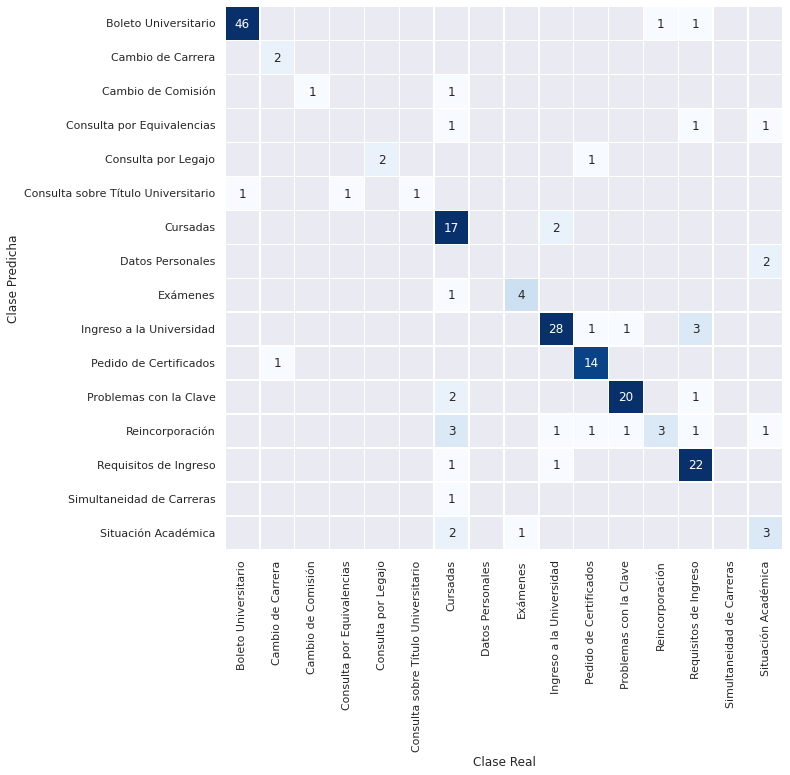

In [27]:
def matriz_confusion(y_real, y_predictions):
  """
  Grafica una matriz de confusión con seaborn en función de la clase observada
  y la clase predicha.
  """

  import numpy as np
  from sklearn import metrics
  import seaborn as sns
  import matplotlib.pyplot as plt

  matriz_confusion = metrics.confusion_matrix(y_real, y_predictions)
  etiquetas = y_predictions.unique()

  sns.set()
  my_mask = np.zeros((matriz_confusion.shape[0], matriz_confusion.shape[0]), dtype=int)
  for i in range(matriz_confusion.shape[0]):
      for j in range(matriz_confusion.shape[0]):
          my_mask[i][j] = matriz_confusion[i][j] == 0 
    
  fig_dims = (10, 10)
  plt.subplots(figsize=fig_dims)

  ax = sns.heatmap(matriz_confusion,
                  xticklabels=etiquetas,
                  annot=True, 
                  fmt="d", 
                  linewidths=.5, 
                  cmap="Blues", 
                  cbar=False, 
                  mask=my_mask, 
                  vmax=15)

  plt.gcf().set_size_inches(10, 10)
  plt.xticks(rotation=90, ha="center")
  plt.yticks(np.arange(len(etiquetas))+0.5, etiquetas, rotation='horizontal')

  plt.xlabel('Clase Real')
  plt.ylabel('Clase Predicha');

  plt.show()

# Referencias
- imbalanced-learn documentation https://imbalanced-learn.org/
- sklearn.model_selection.GridSearchCV https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- ML Pipelines using scikit-learn and GridSearchCV https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05